# Logistic Regression Baseline

The following notebook will serve as a notebook to implement a Logistic Regression model to obtain a baseline measurement for our loss function in developing our models.

## Read Data and Import Libraries

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
#Read in all our data sets and one week's worth of data
games = pd.read_csv("../Data/games.csv")
players = pd.read_csv("../Data/players.csv")
plays = pd.read_csv("../Data/plays.csv")
tackles = pd.read_csv("../Data/tackles.csv")
tracking = pd.read_csv("../Data/tracking_week_1.csv")

In [3]:
display(tracking)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.370000,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.470000,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.560000,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.640000,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.720000,26.80,1.29,1.24,0.13,233.36,141.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407434,2022091200,3826,NaN,football,49,2022-09-12 23:05:57.799999,NaN,football,left,56.220001,9.89,2.56,1.25,0.25,NaN,NaN,tackle
1407435,2022091200,3826,NaN,football,50,2022-09-12 23:05:57.900000,NaN,football,left,56.060001,10.08,2.50,1.14,0.24,NaN,NaN,NaN
1407436,2022091200,3826,NaN,football,51,2022-09-12 23:05:58.000000,NaN,football,left,55.889999,10.27,2.38,1.70,0.25,NaN,NaN,NaN
1407437,2022091200,3826,NaN,football,52,2022-09-12 23:05:58.099999,NaN,football,left,55.730000,10.44,2.07,2.83,0.24,NaN,NaN,NaN


## Data Preperation

The following section will prepare the data for the logistic regression model. This will include: 
- Apply function to add football_x and football_y to all observations 
- Apply function to add ball_carrier data for each row
- Obtain tackle variable, 4 different scenarios as possible dependent variables
- Keep all variables for model or feature engineering
- Merge dataframes (including tha ball carrier information)
- Drop offensive players
- Feature engineer for correct win Probability as well as binary feature for the game being home or away for defense
- Obtain only variables needed for modeling

### Apply function to add football_x and football_y to all observations

In [17]:
#Function to obtain the absolute football_x and football_y
def football_absolute_position(tracking):
    #Obtain football x and y positions for only the football identification
    football_data = tracking[tracking["displayName"]=="football"][["gameId","playId","frameId","x","y"]]

    #Rename x and y position to football_x and football_y
    football_data = football_data.rename(columns = {"x":"football_x", "y": "football_y"})
    
    #return the neccessary identification variables along with the new features
    return football_data[["gameId","playId","frameId", "football_x", "football_y"]]

In [18]:
tracking_with_football_position = football_absolute_position(tracking)
display(tracking_with_football_position)

,gameId,playId,frameId,football_x,football_y
484,2022090800,56,1,85.050003,33.810001
485,2022090800,56,2,83.150002,34.830002
486,2022090800,56,3,81.739998,35.590000
487,2022090800,56,4,80.139999,36.450001
488,2022090800,56,5,79.290001,36.930000
...,...,...,...,...,...
1407434,2022091200,3826,49,56.220001,9.890000
1407435,2022091200,3826,50,56.060001,10.080000
1407436,2022091200,3826,51,55.889999,10.270000
1407437,2022091200,3826,52,55.730000,10.440000


In [19]:
tracking = pd.merge(tracking, tracking_with_football_position, on = ["gameId", "playId", "frameId"])

In [20]:
display(tracking)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,football_x,football_y
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,85.050003,33.810001
1,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,85.050003,33.810001
2,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.200000,99.0,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,85.050003,33.810001
3,2022090800,56,42392.0,Mitch Morse,1,2022-09-08 20:24:05.200000,60.0,BUF,left,88.25,28.74,0.67,1.97,0.07,244.21,30.29,NaN,85.050003,33.810001
4,2022090800,56,42489.0,Stefon Diggs,1,2022-09-08 20:24:05.200000,14.0,BUF,left,80.60,38.29,6.23,0.90,0.62,140.05,189.38,NaN,85.050003,33.810001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407434,2022091200,3826,52526.0,Albert Okwuegbunam,53,2022-09-12 23:05:58.200000,85.0,DEN,left,53.39,13.69,1.84,2.76,0.20,123.00,169.13,NaN,55.570000,10.570000
1407435,2022091200,3826,53464.0,Javonte Williams,53,2022-09-12 23:05:58.200000,33.0,DEN,left,55.72,10.96,1.01,3.05,0.12,277.39,320.94,NaN,55.570000,10.570000
1407436,2022091200,3826,54505.0,Boye Mafe,53,2022-09-12 23:05:58.200000,53.0,SEA,left,56.65,7.97,0.18,2.09,0.01,34.58,225.96,NaN,55.570000,10.570000
1407437,2022091200,3826,54618.0,Tariq Woolen,53,2022-09-12 23:05:58.200000,27.0,SEA,left,51.31,7.39,1.80,1.37,0.18,30.36,39.03,NaN,55.570000,10.570000


### Obtain tackle variable, where tackle is either a full tackle or an assist

In [6]:
display(tackles)

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0
...,...,...,...,...,...,...,...
17421,2022091113,2494,43533,0,0,0,1
17422,2022092502,3510,42406,0,0,0,1
17423,2022091113,3642,43478,0,0,0,1
17424,2022091901,3578,42431,0,0,0,1


In [7]:
print("Number of observations for tackle:", sum(tackles["tackle"]))
print("Number of observations for assist:", sum(tackles["assist"]))
print("Number of observations for both a tackle and assist for a player on a play:", 
      sum((tackles["tackle"]==1) == (tackles["assist"]==1)))

Number of observations for tackle: 9919
Number of observations for assist: 5494
Number of observations for both a tackle and assist for a player on a play: 2013


In [8]:
#just add tackle and assist to give us a tackle value where it dependent variable is a tackle or assist
tackles["tackle"] = tackles["tackle"] + tackles["assist"]

In [9]:
print("Number of observations for tackle:", sum(tackles["tackle"]))
print("Number of observations for assist:", sum(tackles["assist"]))
print("Number of observations for both a tackle and assist for a player on a play:", 
      sum((tackles["tackle"]==1) == (tackles["assist"]==1)))

Number of observations for tackle: 15413
Number of observations for assist: 5494
Number of observations for both a tackle and assist for a player on a play: 7507


### Remove all variables that we are not interested in modeling

In [10]:
#Keep variables in players.csv: 
#nflId
#postition
#weight 
players = players[["nflId", "weight", "position"]]

display(players.head())

,nflId,weight,position
0,25511,225,QB
1,29550,328,T
2,29851,225,QB
3,30842,267,TE
4,33084,217,QB


In [11]:
#Keep variables in plays.csv:
#gameId
#playId
#ballCarrierId
#down
#yardsToGo
#defensiveTeam
#absoluteYardlineNumber
#offensiveFormation
#defendersInTheBox
#passProbability 
#preSnapHomeTeamWinProbability
plays = plays[["gameId","playId", "ballCarrierId", "down", "yardsToGo", "defensiveTeam", "absoluteYardlineNumber",
               "offenseFormation", "defendersInTheBox", "passProbability", "preSnapHomeTeamWinProbability"]]

display(plays.head())

,gameId,playId,ballCarrierId,down,yardsToGo,defensiveTeam,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability
0,2022100908,3537,48723,1,10,TB,69,SHOTGUN,7.0,0.747284,0.976785
1,2022091103,3126,52457,1,10,CIN,76,SHOTGUN,7.0,0.416454,0.160485
2,2022091111,1148,42547,2,5,LAC,40,I_FORM,6.0,0.267933,0.756661
3,2022100212,2007,46461,2,10,LV,47,SINGLEBACK,6.0,0.592704,0.620552
4,2022091900,1372,47857,1,10,TEN,75,I_FORM,7.0,0.470508,0.836290


In [12]:
#Keep variables in tracking data: 
#gameId
#playId
#frameId
#nflId
#club
#x
#y
#s
#a
#o
#
#dir
#football_x
#football_y
tracking = tracking[["gameId","playId","frameId","nflId","club","x","y","s","a","o","dir","football_x", "football_y"]]


display(tracking.head())

,gameId,playId,frameId,nflId,club,x,y,s,a,o,dir,football_x,football_y
0,2022090800,56,1,35472.0,BUF,88.37,27.27,1.62,1.15,231.74,147.90,85.050003,33.810001
1,2022090800,56,1,38577.0,LA,78.25,27.53,1.24,3.81,4.20,331.67,85.050003,33.810001
2,2022090800,56,1,41239.0,LA,91.08,31.61,3.91,2.34,168.33,132.02,85.050003,33.810001
3,2022090800,56,1,42392.0,BUF,88.25,28.74,0.67,1.97,244.21,30.29,85.050003,33.810001
4,2022090800,56,1,42489.0,BUF,80.60,38.29,6.23,0.90,140.05,189.38,85.050003,33.810001


In [13]:
#Keep variables in tackles.csv:
#gameId
#playId
#nflId
#tackle
tackles = tackles[["gameId","playId", "nflId", "tackle"]]

display(tackles.head())

,gameId,playId,nflId,tackle
0,2022090800,101,42816,1
1,2022090800,393,46232,1
2,2022090800,486,40166,1
3,2022090800,646,47939,1
4,2022090800,818,40107,1


In [14]:
#Keep variables in games.csv:
#gameId
#homeTeamAbbr
games = games[["gameId", "homeTeamAbbr"]]
display(games.head())

,gameId,homeTeamAbbr
0,2022090800,LA
1,2022091100,ATL
2,2022091101,CAR
3,2022091102,CHI
4,2022091103,CIN


### Merge Dataframes

In [25]:
#first left join the tracking with players on nflId for each of the players
merged_df = pd.merge(tracking,players, on = ["nflId"], how = 'left')

print(len(merged_df))

#join plays with players to obtain the information needed for the ball carrier on a given play
#rename columns to ballCarrier variables
#drop the nflId for ballCarrier
plays_ball_carrier = pd.merge(plays,players, left_on = "ballCarrierId", right_on = "nflId", how = "left")\
                     .rename(columns = {"weight":"weight_ballCarrier",
                                       "position": "position_ballCarrier"})\
                     .drop(columns = ["nflId"])

#Merge plays_ball_carrier with the merged dataframe of tracking and players 
merged_df = pd.merge(merged_df,plays, on = ["gameId", "playId"], how = 'left')
print(len(merged_df))

#Merge games with merged dataframe of tracking, players, and plays
merged_df = pd.merge(merged_df,games, on = ["gameId"], how = 'left')
print(len(merged_df))

#Merge tackles with games, players, plays, and tracking
merged_df = pd.merge(merged_df,tackles, on = ["gameId", "playId","nflId"], how = 'left')
display(merged_df.head())

1346246
1346246
1346246


,gameId,playId,frameId,nflId,club,x,y,s,a,o,dir,football_x,football_y,weight,position,ballCarrierId,down,yardsToGo,defensiveTeam,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,homeTeamAbbr,tackle
0,2022090800,56,1,35472.0,BUF,88.37,27.27,1.62,1.15,231.74,147.90,85.050003,33.810001,325,G,42489,1,10,LA,85,SHOTGUN,6.0,0.689960,0.413347,LA,NaN
1,2022090800,56,1,38577.0,LA,78.25,27.53,1.24,3.81,4.20,331.67,85.050003,33.810001,242,ILB,42489,1,10,LA,85,SHOTGUN,6.0,0.689960,0.413347,LA,NaN
2,2022090800,56,1,41239.0,LA,91.08,31.61,3.91,2.34,168.33,132.02,85.050003,33.810001,280,DT,42489,1,10,LA,85,SHOTGUN,6.0,0.689960,0.413347,LA,NaN
3,2022090800,56,1,42392.0,BUF,88.25,28.74,0.67,1.97,244.21,30.29,85.050003,33.810001,305,C,42489,1,10,LA,85,SHOTGUN,6.0,0.689960,0.413347,LA,NaN
4,2022090800,56,1,42489.0,BUF,80.60,38.29,6.23,0.90,140.05,189.38,85.050003,33.810001,191,WR,42489,1,10,LA,85,SHOTGUN,6.0,0.689960,0.413347,LA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346241,2022091200,3826,53,52491.0,DEN,60.01,15.63,3.52,1.71,223.70,231.77,55.570000,10.570000,315,C,53464,3,14,SEA,65,SHOTGUN,3.0,0.916875,0.508994,SEA,NaN
1346242,2022091200,3826,53,52526.0,DEN,53.39,13.69,1.84,2.76,123.00,169.13,55.570000,10.570000,255,TE,53464,3,14,SEA,65,SHOTGUN,3.0,0.916875,0.508994,SEA,NaN
1346243,2022091200,3826,53,53464.0,DEN,55.72,10.96,1.01,3.05,277.39,320.94,55.570000,10.570000,220,RB,53464,3,14,SEA,65,SHOTGUN,3.0,0.916875,0.508994,SEA,NaN
1346244,2022091200,3826,53,54505.0,SEA,56.65,7.97,0.18,2.09,34.58,225.96,55.570000,10.570000,265,OLB,53464,3,14,SEA,65,SHOTGUN,3.0,0.916875,0.508994,SEA,NaN


In [27]:
#For any NAN values for tackle, that means that the player did not have a tackle on a play, so give them a 0
merged_df["tackle"].fillna(0,inplace = True)

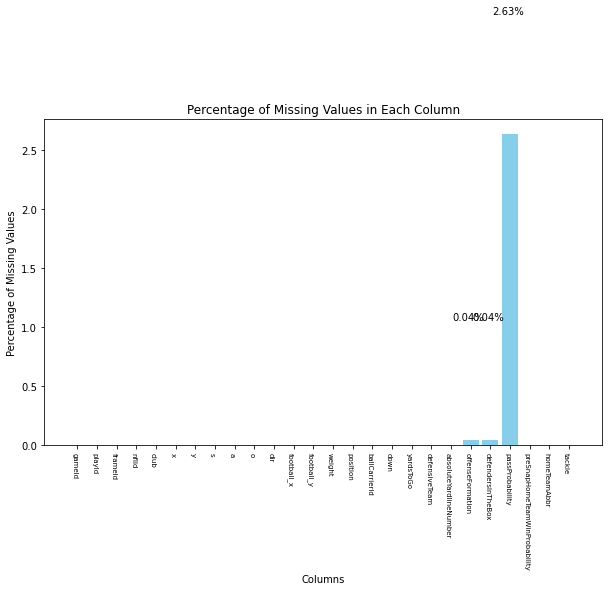

In [28]:
# Calculate the percentage of missing values for each column
missing_percentages = (merged_df.isnull().mean() * 100).round(2)

# Plot the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(missing_percentages.index, missing_percentages.values, color='skyblue')

# Annotate bars with percentages for values greater than 0
annotations = []
for bar, percentage in zip(bars, missing_percentages):
    if percentage > 0:
        annotation = plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 1,
                              f'{percentage}%', ha='center', va='bottom', fontsize=10)
        annotations.append(annotation)

# Adjust the rotation and font size of x-axis labels
plt.xticks(rotation=270, ha='right', fontsize=7)


plt.title('Percentage of Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.show()

### Drop offensive tracking

In [33]:
merged_df_def = merged_df[(merged_df["club"])==(merged_df["defensiveTeam"])]
print(len(merged_df_def))

673123


### Feature engineer for correct win Probability as well as binary feature for the game being home or away for defense

In [40]:
#If the club does not equal the home team, them binary value for home and then correct the win probability for defense
merged_df_def["home"] = (merged_df_def["club"]== merged_df_def["homeTeamAbbr"]).astype(int)
merged_df_def["preSnapWinProbabilityDefense"] = merged_df_def.\
                apply(lambda row: row['preSnapHomeTeamWinProbability'] if row["home"]==1 else
                     1 - row['preSnapHomeTeamWinProbability'], axis = 1)

display(merged_df_def.head())

,gameId,playId,frameId,nflId,club,x,y,s,a,o,dir,football_x,football_y,weight,position,ballCarrierId,down,yardsToGo,defensiveTeam,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,homeTeamAbbr,tackle,home,preSnapWinProbabilityDefense
1,2022090800,56,1,38577.0,LA,78.25,27.53,1.24,3.81,4.20,331.67,85.050003,33.810001,242,ILB,42489,1,10,LA,85,SHOTGUN,6.0,0.68996,0.413347,LA,0.0,1,0.413347
2,2022090800,56,1,41239.0,LA,91.08,31.61,3.91,2.34,168.33,132.02,85.050003,33.810001,280,DT,42489,1,10,LA,85,SHOTGUN,6.0,0.68996,0.413347,LA,0.0,1,0.413347
5,2022090800,56,1,42816.0,LA,72.34,7.81,4.36,0.91,338.33,257.23,85.050003,33.810001,184,CB,42489,1,10,LA,85,SHOTGUN,6.0,0.68996,0.413347,LA,0.0,1,0.413347
6,2022090800,56,1,43294.0,LA,77.95,40.78,5.50,3.00,139.54,172.50,85.050003,33.810001,208,CB,42489,1,10,LA,85,SHOTGUN,6.0,0.68996,0.413347,LA,1.0,1,0.413347
7,2022090800,56,1,43298.0,LA,91.99,33.78,1.86,4.76,155.94,136.01,85.050003,33.810001,240,DE,42489,1,10,LA,85,SHOTGUN,6.0,0.68996,0.413347,LA,0.0,1,0.413347


In [39]:
display(display(merged_df_def[merged_df_def["home"]==0].head()))

,gameId,playId,frameId,nflId,club,x,y,s,a,o,dir,football_x,football_y,weight,position,ballCarrierId,down,yardsToGo,defensiveTeam,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,homeTeamAbbr,tackle,home,preSnapWinProbabilityDefense
6645,2022090800,299,1,37075.0,BUF,27.46,28.35,0.00,0.00,281.71,139.43,26.719999,23.68,250,OLB,47853,1,10,BUF,27,SINGLEBACK,6.0,0.527559,0.269681,LA,0.0,0,0.730319
6646,2022090800,299,1,40107.0,BUF,40.29,19.31,1.85,2.30,304.33,26.76,26.719999,23.68,197,FS,47853,1,10,BUF,27,SINGLEBACK,6.0,0.527559,0.269681,LA,0.0,0,0.730319
6647,2022090800,299,1,40166.0,BUF,36.60,31.85,3.72,2.92,267.44,292.47,26.719999,23.68,191,SS,47853,1,10,BUF,27,SINGLEBACK,6.0,0.527559,0.269681,LA,0.0,0,0.730319
6649,2022090800,299,1,41341.0,BUF,26.98,21.19,0.00,0.00,293.65,164.37,26.719999,23.68,322,DT,47853,1,10,BUF,27,SINGLEBACK,6.0,0.527559,0.269681,LA,0.0,0,0.730319
6653,2022090800,299,1,44976.0,BUF,30.75,20.03,1.53,3.11,277.09,359.75,26.719999,23.68,223,OLB,47853,1,10,BUF,27,SINGLEBACK,6.0,0.527559,0.269681,LA,0.0,0,0.730319


None

### Obtain only variables needed for modeling


In [42]:
#Drop variables: 
#club
#ballCarrierId
#defensiveTeam
#homeTeamAbbr
df = merged_df_def.drop(columns = ["nflId","club", "ballCarrierId", "defensiveTeam", "homeTeamAbbr"])
display(df.head())

,gameId,playId,frameId,x,y,s,a,o,dir,football_x,football_y,weight,position,down,yardsToGo,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,tackle,home,preSnapWinProbabilityDefense
1,2022090800,56,1,78.25,27.53,1.24,3.81,4.20,331.67,85.050003,33.810001,242,ILB,1,10,85,SHOTGUN,6.0,0.68996,0.413347,0.0,1,0.413347
2,2022090800,56,1,91.08,31.61,3.91,2.34,168.33,132.02,85.050003,33.810001,280,DT,1,10,85,SHOTGUN,6.0,0.68996,0.413347,0.0,1,0.413347
5,2022090800,56,1,72.34,7.81,4.36,0.91,338.33,257.23,85.050003,33.810001,184,CB,1,10,85,SHOTGUN,6.0,0.68996,0.413347,0.0,1,0.413347
6,2022090800,56,1,77.95,40.78,5.50,3.00,139.54,172.50,85.050003,33.810001,208,CB,1,10,85,SHOTGUN,6.0,0.68996,0.413347,1.0,1,0.413347
7,2022090800,56,1,91.99,33.78,1.86,4.76,155.94,136.01,85.050003,33.810001,240,DE,1,10,85,SHOTGUN,6.0,0.68996,0.413347,0.0,1,0.413347


## Logistic Regression Model

In [ ]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Create a new column for stratification
df["Id"] = df["gameId"] + '_' + df["playId"] + "_" + df["frameId"]

#drop old variables
df = df.drop(columns = ["gameId","playId","frameId"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = df["playId"])